In [ ]:
import numpy as np     
import pandas as pd    
from pandas.plotting import autocorrelation_plot as auto_corr

# To plot
import matplotlib.pyplot as plt  
%matplotlib inline    
import matplotlib as mpl
import seaborn as sns

#For date-time
import math
from datetime import datetime
from datetime import timedelta


from neuralprophet import NeuralProphet
from darts import TimeSeries

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose as season
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor


# !pip install pmdarima
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima


import warnings
warnings.filterwarnings("ignore")

In [ ]:
# pip install numpy

  Using cached numpy-2.0.2-cp39-cp39-win_amd64.whl.metadata (59 kB)
Using cached numpy-2.0.2-cp39-cp39-win_amd64.whl (15.9 MB)
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mediapipe 0.10.21 requires numpy<2, but you have numpy 2.0.2 which is incompatible.


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
from prophet import Prophet

In [6]:
def metrics(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    return {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }

In [7]:
def plot_model(train, test, y_pred, model_name = ""):
    plt.figure(figsize=(20,6))
    plt.title(f'Prediction of Weekly Sales Using {model_name}', fontsize=20)
    plt.plot(train, label='Train')
    plt.plot(test, label='Test')
    plt.plot(y_pred, label=f'Prediction of {model_name}')
    plt.legend(loc='best')
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Weekly Sales', fontsize=14)
    plt.show()

In [47]:
def deep_plot_model(train, test, y_pred, model_name="", n_steps=0):
    plt.figure(figsize=(20,6))
    plt.title(f'Prediction of Weekly Sales Using {model_name}', fontsize=20)
    
    # Plot train and test
    plt.plot(train.index, train.values, label='Train')
    plt.plot(test.index, test.values, label='Test')
    
    # Align prediction with correct position in test set
    y_pred_aligned = [np.nan] * n_steps + list(y_pred)
    plt.plot(test.index, y_pred_aligned, label=f'Prediction of {model_name}')
    
    plt.legend(loc='best')
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Weekly Sales', fontsize=14)
    plt.show()

In [8]:
df = pd.read_csv('../data/project_dataset.csv')

In [20]:
df.head()

,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
0,2010-02-05,0,1.0,24924.50,42.31,2.572,211.096358,8.106
1,2010-02-05,0,26.0,11737.12,42.31,2.572,211.096358,8.106
2,2010-02-05,0,17.0,13223.76,42.31,2.572,211.096358,8.106
3,2010-02-05,0,45.0,37.44,42.31,2.572,211.096358,8.106
4,2010-02-05,0,28.0,1085.29,42.31,2.572,211.096358,8.106


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10244 entries, 0 to 10243
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          10244 non-null  object 
 1   IsHoliday     10244 non-null  int64  
 2   Dept          10244 non-null  float64
 3   Weekly_Sales  10244 non-null  float64
 4   Temperature   10244 non-null  float64
 5   Fuel_Price    10244 non-null  float64
 6   CPI           10244 non-null  float64
 7   Unemployment  10244 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 640.4+ KB


In [9]:
df = df[df['Dept'] == 2]
df.head()

,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
22,2010-02-05,0,2.0,50605.27,42.31,2.572,211.096358,8.106
133,2010-02-12,1,2.0,44682.74,38.51,2.548,211.242170,8.106
186,2010-02-19,0,2.0,47928.89,39.93,2.514,211.289143,8.106
241,2010-02-26,0,2.0,44292.87,46.63,2.561,211.319643,8.106
321,2010-03-05,0,2.0,48397.98,46.50,2.625,211.350143,8.106


In [42]:
df.shape

(143, 8)

In [43]:
df['Dept'].nunique()

1

In [10]:
mapping = {0: False, 1: True}
df['IsHoliday'] = df['IsHoliday'].map(mapping)

```I will have a look at the dataset  to see if there is any weird values or not.```

In [45]:
df.describe()

,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
count,143.0,143.000000,143.000000,143.000000,143.000000,143.000000
mean,2.0,46102.090420,68.306783,3.219699,215.996892,7.610420
std,0.0,3440.673222,14.250486,0.427313,4.350890,0.383749
min,2.0,35819.830000,35.400000,2.514000,210.337426,6.573000
25%,2.0,44170.460000,58.265000,2.764500,211.549277,7.348000
50%,2.0,45561.850000,69.640000,3.290000,215.459905,7.787000
75%,2.0,47612.245000,80.485000,3.594000,220.531330,7.838000
max,2.0,65615.360000,91.650000,3.907000,223.444251,8.106000


``` Great! there's no null values ```

In [46]:
df.isnull().sum()

Date            0
IsHoliday       0
Dept            0
Weekly_Sales    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [47]:
df['Date'].head(5) # to see first 5 rows.

22     2010-02-05
133    2010-02-12
186    2010-02-19
241    2010-02-26
321    2010-03-05
Name: Date, dtype: object

In [48]:
df['Date'].tail(5) # to see last 5 rows.

9921     2012-09-28
10002    2012-10-05
10062    2012-10-12
10103    2012-10-19
10176    2012-10-26
Name: Date, dtype: object

``` So our data range is from 5th of February 2010 to 26th of October 2012.```

``` Investegating IsHoliday column, we could be able to derive some insights from it  ```

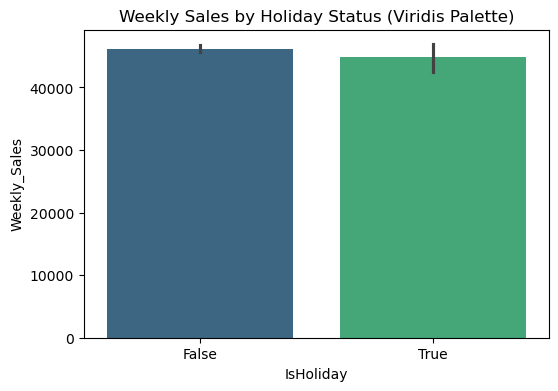

In [49]:
plt.figure(figsize=(6, 4))
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=df, palette='viridis')
plt.title('Weekly Sales by Holiday Status (Viridis Palette)')
plt.show()

In [50]:
df_holiday = df.loc[df['IsHoliday']==True]
df_holiday['Date'].unique() 

array(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07'], dtype=object)

Missing Holiday Data
--------------------

Your dataset doesn't contain all the holiday information. We've identified four key holidays and their dates for 2010 through 2013:

-   **Super Bowl:** February 12, 2010; February 11, 2011; February 10, 2012; February 8, 2013
-   **Labor Day:** September 10, 2010; September 9, 2011; September 7, 2012; September 6, 2013
-   **Thanksgiving:** November 26, 2010; November 25, 2011; November 23, 2012; November 29, 2013
-   **Christmas:** December 31, 2010; December 30, 2011; December 28, 2012; December 27, 2013

In [11]:
# Super bowl dates in train set
df.loc[(df['Date'] == '2010-02-12')|(df['Date'] == '2011-02-11')|(df['Date'] == '2012-02-10'),'Super_Bowl'] = True
df.loc[(df['Date'] != '2010-02-12')&(df['Date'] != '2011-02-11')&(df['Date'] != '2012-02-10'),'Super_Bowl'] = False

In [12]:
# Labor day dates in train set
df.loc[(df['Date'] == '2010-09-10')|(df['Date'] == '2011-09-09')|(df['Date'] == '2012-09-07'),'Labor_Day'] = True
df.loc[(df['Date'] != '2010-09-10')&(df['Date'] != '2011-09-09')&(df['Date'] != '2012-09-07'),'Labor_Day'] = False

In [13]:
# Thanksgiving dates in train set
df.loc[(df['Date'] == '2010-11-26')|(df['Date'] == '2011-11-25'),'Thanksgiving'] = True
df.loc[(df['Date'] != '2010-11-26')&(df['Date'] != '2011-11-25'),'Thanksgiving'] = False

In [14]:
#Christmas dates in train set
df.loc[(df['Date'] == '2010-12-31')|(df['Date'] == '2011-12-30'),'Christmas'] = True
df.loc[(df['Date'] != '2010-12-31')&(df['Date'] != '2011-12-30'),'Christmas'] = False

<Axes: xlabel='Christmas', ylabel='Weekly_Sales'>

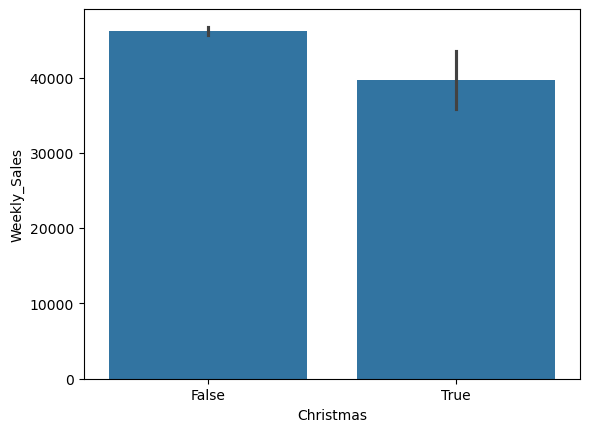

In [55]:
sns.barplot(x='Christmas', y='Weekly_Sales', data=df) # Christmas holiday vs not-Christmas

<Axes: xlabel='Thanksgiving', ylabel='Weekly_Sales'>

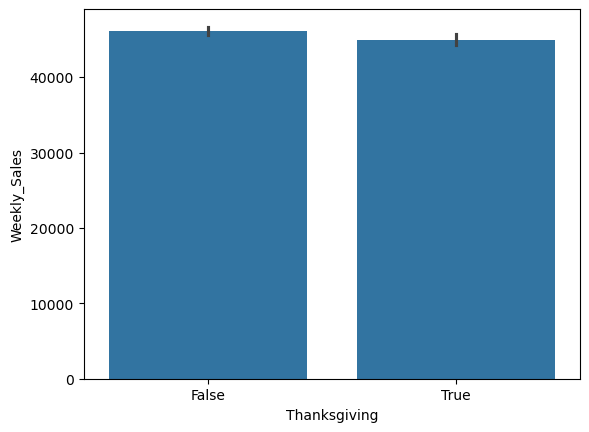

In [56]:
sns.barplot(x='Thanksgiving', y='Weekly_Sales', data=df) # Thanksgiving holiday vs not-thanksgiving

<Axes: xlabel='Super_Bowl', ylabel='Weekly_Sales'>

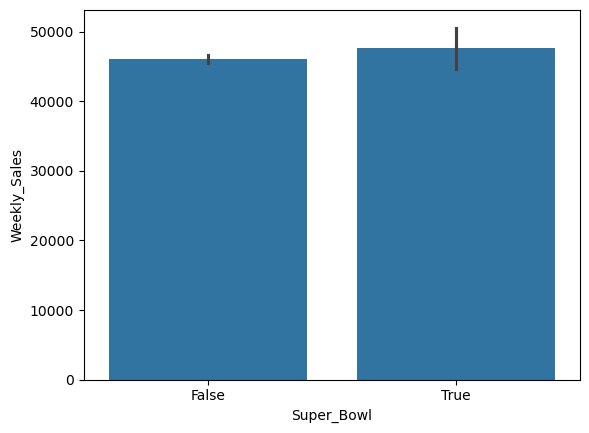

In [57]:
sns.barplot(x='Super_Bowl', y='Weekly_Sales', data=df) # Super bowl holiday vs not-super bowl

<Axes: xlabel='Labor_Day', ylabel='Weekly_Sales'>

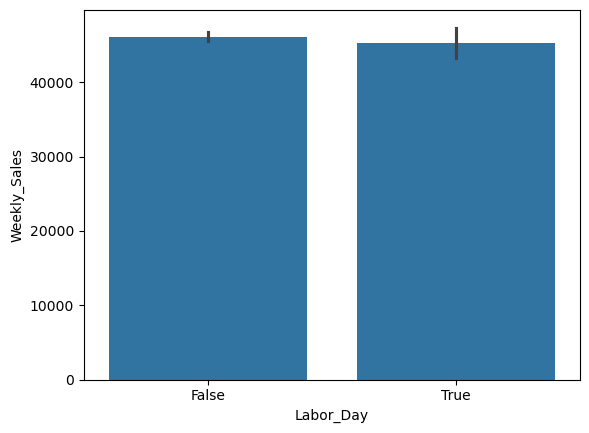

In [58]:
sns.barplot(x='Labor_Day', y='Weekly_Sales', data=df) # Labor day holiday vs not-labor day

Analysis of Weekly Sales by Holiday

The data indicates that **Labor Day and Christmas do not significantly boost average weekly sales**. While **Super Bowl has a positive impact**

In [59]:
df.sort_values(by='Weekly_Sales',ascending=False).head(5)

,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Super_Bowl,Labor_Day,Thanksgiving,Christmas
7076,2011-12-23,False,2.0,65615.36,47.96,3.112,219.357722,7.866,False,False,False,False
3341,2010-12-24,False,2.0,59889.32,52.33,2.886,211.405122,7.838,False,False,False,False
7472,2012-02-03,False,2.0,54322.24,56.55,3.360,220.172015,7.348,False,False,False,False
4069,2011-03-04,False,2.0,53035.54,59.58,3.288,213.823333,7.742,False,False,False,False
7814,2012-03-02,False,2.0,52608.51,60.96,3.630,220.848045,7.348,False,False,False,False


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 143 entries, 22 to 10176
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          143 non-null    object 
 1   IsHoliday     143 non-null    bool   
 2   Dept          143 non-null    float64
 3   Weekly_Sales  143 non-null    float64
 4   Temperature   143 non-null    float64
 5   Fuel_Price    143 non-null    float64
 6   CPI           143 non-null    float64
 7   Unemployment  143 non-null    float64
 8   Super_Bowl    143 non-null    object 
 9   Labor_Day     143 non-null    object 
 10  Thanksgiving  143 non-null    object 
 11  Christmas     143 non-null    object 
dtypes: bool(1), float64(6), object(5)
memory usage: 13.5+ KB


# Changing Date to Datetime and Creating New Columns

In [15]:
# Convert 'Date' column to datetime objects
df["Date"] = pd.to_datetime(df["Date"])

# Corrected way to get week, month, and year

# For week number (ISO standard week)
df['week'] = df['Date'].dt.isocalendar().week.astype(int) # .astype(int) to get integer type

# For month
df['month'] = df['Date'].dt.month

# For year
df['year'] = df['Date'].dt.year

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 143 entries, 22 to 10176
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          143 non-null    datetime64[ns]
 1   IsHoliday     143 non-null    bool          
 2   Dept          143 non-null    float64       
 3   Weekly_Sales  143 non-null    float64       
 4   Temperature   143 non-null    float64       
 5   Fuel_Price    143 non-null    float64       
 6   CPI           143 non-null    float64       
 7   Unemployment  143 non-null    float64       
 8   Super_Bowl    143 non-null    object        
 9   Labor_Day     143 non-null    object        
 10  Thanksgiving  143 non-null    object        
 11  Christmas     143 non-null    object        
 12  week          143 non-null    int32         
 13  month         143 non-null    int32         
 14  year          143 non-null    int32         
dtypes: bool(1), datetime64[ns](1), float64(6),

In [63]:
df.groupby('month')['Weekly_Sales'].mean() # to see the best months for sales

month
1     42431.477500
2     47947.536667
3     46809.176154
4     46172.491429
5     45979.411667
6     46334.059231
7     45321.640000
8     47854.676923
9     45204.323846
10    44255.126923
11    44651.076250
12    49195.156000
Name: Weekly_Sales, dtype: float64

In [64]:
df.groupby('year')['Weekly_Sales'].mean() # to see the best years for sales

year
2010    45844.475833
2011    45950.409423
2012    46573.088372
Name: Weekly_Sales, dtype: float64

TIME SERIES DECOMPOSITION


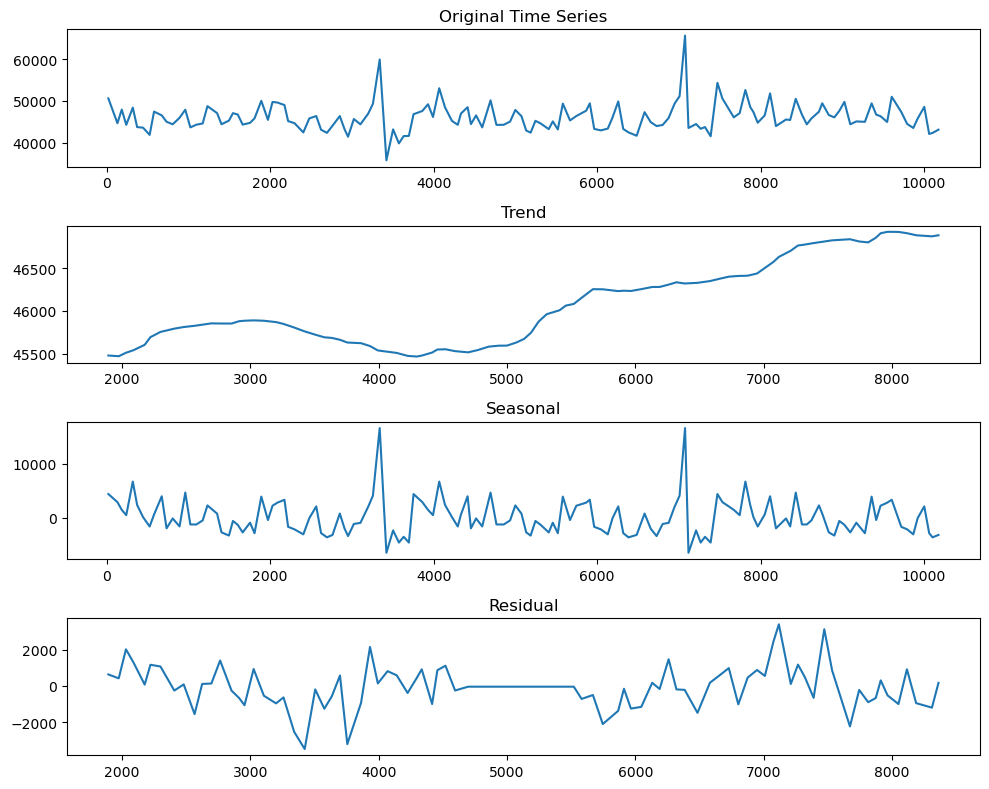

In [28]:
print("TIME SERIES DECOMPOSITION")

decomposition = seasonal_decompose(df['Weekly_Sales'], 
                                 model='additive', 
                                 period=52)  


fig, axes = plt.subplots(4, 1, figsize=(10, 8))

decomposition.observed.plot(ax=axes[0], title='Original Time Series')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
decomposition.resid.plot(ax=axes[3], title='Residual')

plt.tight_layout()
plt.show()

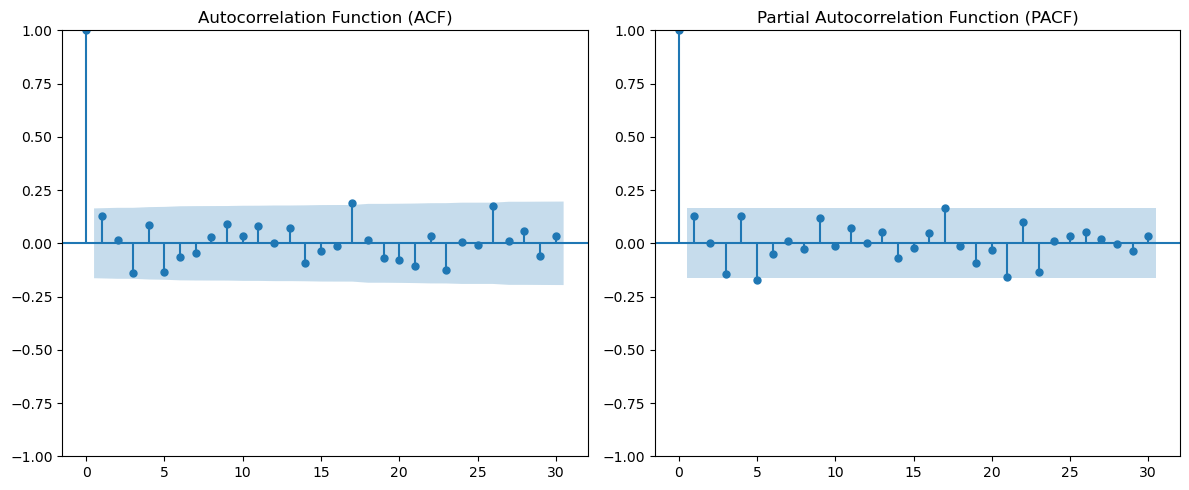

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) # 1 row, 2 columns

plot_acf(df['Weekly_Sales'], ax=axes[0], lags=30, title='Autocorrelation Function (ACF)')
plot_pacf(df['Weekly_Sales'], ax=axes[1], lags=30, title='Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

<Axes: xlabel='month'>

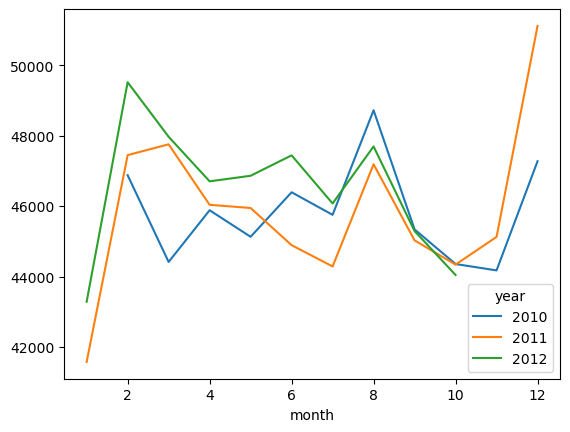

In [65]:
monthly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "month")
monthly_sales.plot()

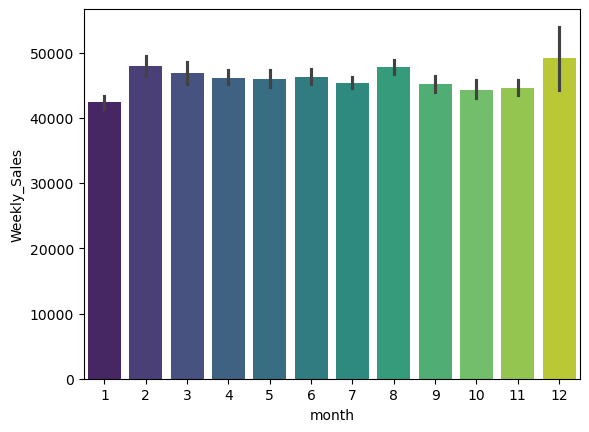

In [93]:
fig = sns.barplot(x='month', y='Weekly_Sales', data=df, palette='viridis')

* * * * *

Looking at the graph, **December and November** have the best sales, which makes sense. Even though Thanksgiving week has the absolute highest sales numbers and maybe also for the reason end of the year sales and black friday and so on, **December actually wins when you look at the average sales**.

In [94]:
df.groupby('week')['Weekly_Sales'].mean().sort_values(ascending=False).head()

week
51    62752.340000
9     51347.343333
5     50585.543333
50    50220.350000
35    49810.100000
Name: Weekly_Sales, dtype: float64

"The five best average sales weeks are the couple of weeks before Christmas, Thanksgiving, Black Friday, and the end of May (when schools close)."

<Axes: xlabel='week'>

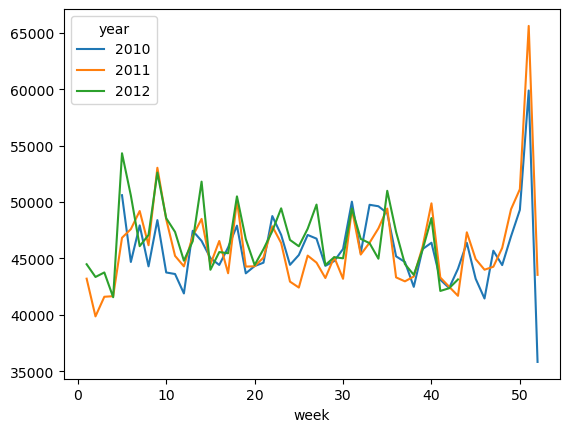

In [95]:
weekly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "week")
weekly_sales.plot()

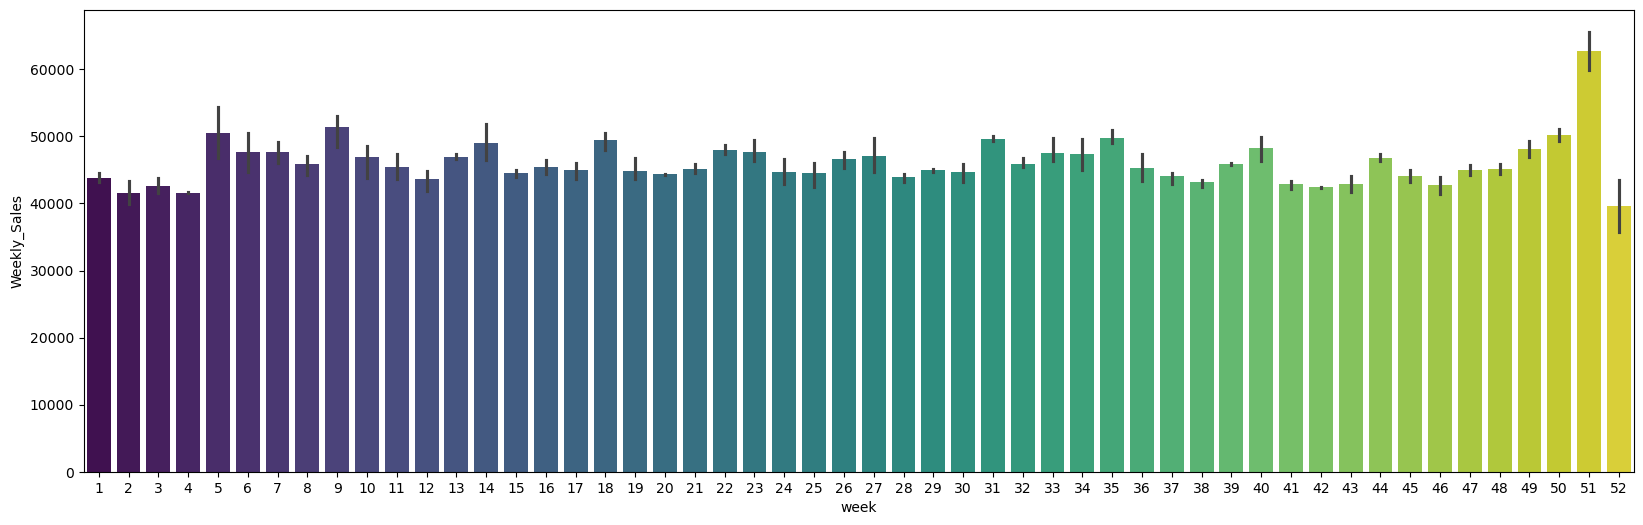

In [97]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='week', y='Weekly_Sales', data=df, palette = 'viridis')

```From graphs, it is seen that 51th week has significantly higher average as Christmas, Thankgiving and Black Friday effects.```

# Fuel Price, CPI , Unemployment , Temperature Effects

<Axes: xlabel='Fuel_Price'>

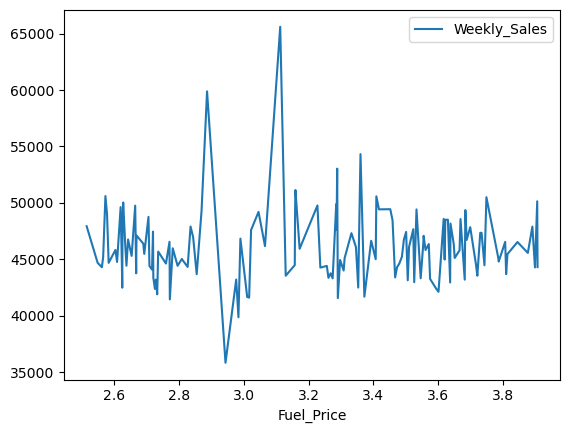

In [99]:
fuel_price = pd.pivot_table(df, values = "Weekly_Sales", index= "Fuel_Price")
fuel_price.plot()

<Axes: xlabel='Temperature'>

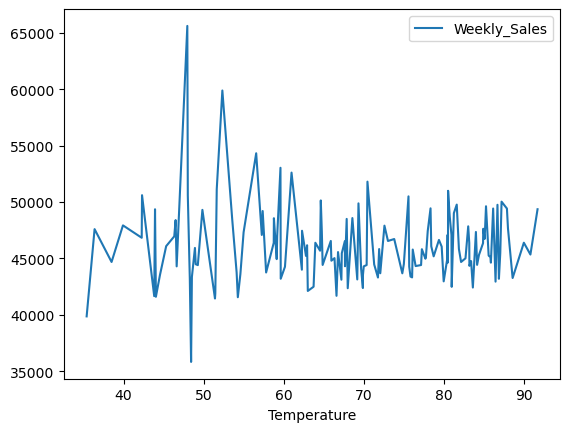

In [100]:
temp = pd.pivot_table(df, values = "Weekly_Sales", index= "Temperature")
temp.plot()

<Axes: xlabel='CPI'>

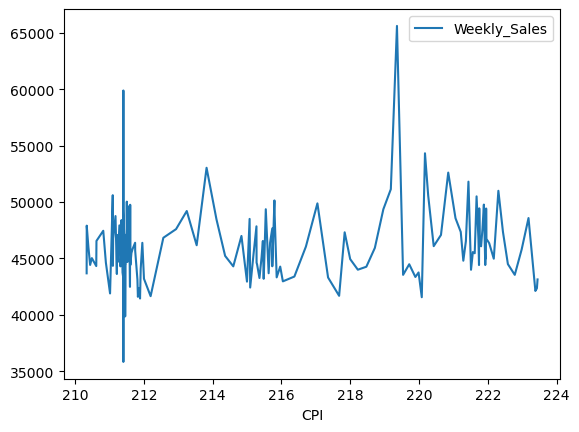

In [101]:
CPI = pd.pivot_table(df, values = "Weekly_Sales", index= "CPI")
CPI.plot()

<Axes: xlabel='Unemployment'>

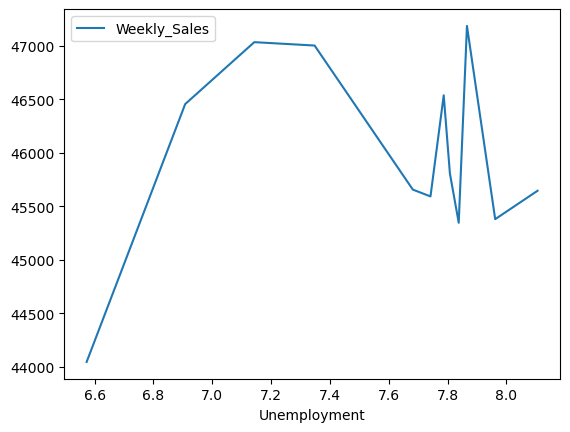

In [102]:
unemployment = pd.pivot_table(df, values = "Weekly_Sales", index= "Unemployment")
unemployment.plot()

"The graphs don't show clear connections between weekly sales and things like prices (CPI), temperature, unemployment, or fuel cost."

# First trail

In [103]:
df.to_csv('clean_data.csv') # assign new data frame to csv for using after here

In [16]:
df = pd.read_csv('..\data\clean_data.csv')

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    143 non-null    int64  
 1   Date          143 non-null    object 
 2   IsHoliday     143 non-null    bool   
 3   Dept          143 non-null    float64
 4   Weekly_Sales  143 non-null    float64
 5   Temperature   143 non-null    float64
 6   Fuel_Price    143 non-null    float64
 7   CPI           143 non-null    float64
 8   Unemployment  143 non-null    float64
 9   Super_Bowl    143 non-null    bool   
 10  Labor_Day     143 non-null    bool   
 11  Thanksgiving  143 non-null    bool   
 12  Christmas     143 non-null    bool   
 13  week          143 non-null    int64  
 14  month         143 non-null    int64  
 15  year          143 non-null    int64  
dtypes: bool(5), float64(6), int64(4), object(1)
memory usage: 13.1+ KB


In [17]:
df['Date'] = pd.to_datetime(df['Date']) # changing datetime to divide if needs

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Unnamed: 0    143 non-null    int64         
 1   Date          143 non-null    datetime64[ns]
 2   IsHoliday     143 non-null    bool          
 3   Dept          143 non-null    float64       
 4   Weekly_Sales  143 non-null    float64       
 5   Temperature   143 non-null    float64       
 6   Fuel_Price    143 non-null    float64       
 7   CPI           143 non-null    float64       
 8   Unemployment  143 non-null    float64       
 9   Super_Bowl    143 non-null    bool          
 10  Labor_Day     143 non-null    bool          
 11  Thanksgiving  143 non-null    bool          
 12  Christmas     143 non-null    bool          
 13  week          143 non-null    int64         
 14  month         143 non-null    int64         
 15  year          143 non-null    int64     

# Encoding the Data 

In [18]:
df_encoded = df.copy() 

In [19]:
df_encoded.head()

,Unnamed: 0,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,22,2010-02-05,False,2.0,50605.27,42.31,2.572,211.096358,8.106,False,False,False,False,5,2,2010
1,133,2010-02-12,True,2.0,44682.74,38.51,2.548,211.242170,8.106,True,False,False,False,6,2,2010
2,186,2010-02-19,False,2.0,47928.89,39.93,2.514,211.289143,8.106,False,False,False,False,7,2,2010
3,241,2010-02-26,False,2.0,44292.87,46.63,2.561,211.319643,8.106,False,False,False,False,8,2,2010
4,321,2010-03-05,False,2.0,48397.98,46.50,2.625,211.350143,8.106,False,False,False,False,9,3,2010


In [20]:
df_encoded.drop(columns=['Unnamed: 0'],inplace=True)

In [21]:
df_encoded.head()

,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,2010-02-05,False,2.0,50605.27,42.31,2.572,211.096358,8.106,False,False,False,False,5,2,2010
1,2010-02-12,True,2.0,44682.74,38.51,2.548,211.242170,8.106,True,False,False,False,6,2,2010
2,2010-02-19,False,2.0,47928.89,39.93,2.514,211.289143,8.106,False,False,False,False,7,2,2010
3,2010-02-26,False,2.0,44292.87,46.63,2.561,211.319643,8.106,False,False,False,False,8,2,2010
4,2010-03-05,False,2.0,48397.98,46.50,2.625,211.350143,8.106,False,False,False,False,9,3,2010


In [22]:
df_encoded['Super_Bowl'] = df_encoded['Super_Bowl'].astype(bool).astype(int) # changing T,F to 0-1
df_encoded['Thanksgiving'] = df_encoded['Thanksgiving'].astype(bool).astype(int) # changing T,F to 0-1
df_encoded['Labor_Day'] = df_encoded['Labor_Day'].astype(bool).astype(int) # changing T,F to 0-1
df_encoded['Christmas'] = df_encoded['Christmas'].astype(bool).astype(int) # changing T,F to 0-1
df_encoded['IsHoliday'] = df_encoded['IsHoliday'].astype(bool).astype(int) # changing T,F to 0-1


In [23]:
df_new = df_encoded.copy()

In [24]:
df_new.head()

,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,2010-02-05,0,2.0,50605.27,42.31,2.572,211.096358,8.106,0,0,0,0,5,2,2010
1,2010-02-12,1,2.0,44682.74,38.51,2.548,211.242170,8.106,1,0,0,0,6,2,2010
2,2010-02-19,0,2.0,47928.89,39.93,2.514,211.289143,8.106,0,0,0,0,7,2,2010
3,2010-02-26,0,2.0,44292.87,46.63,2.561,211.319643,8.106,0,0,0,0,8,2,2010
4,2010-03-05,0,2.0,48397.98,46.50,2.625,211.350143,8.106,0,0,0,0,9,3,2010


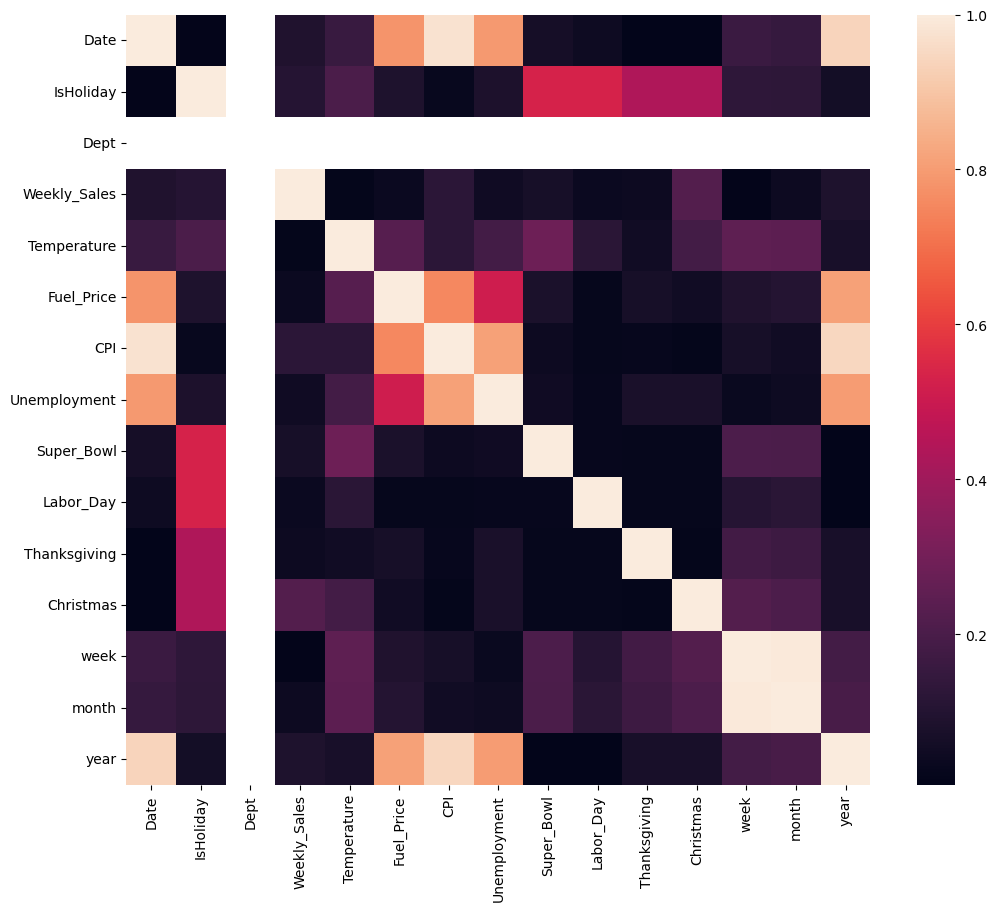

In [22]:
plt.figure(figsize = (12,10))
sns.heatmap(df_new.corr().abs())    # To see the correlations
plt.show()

Since temperature, unemployment, and CPI don't seem to significantly affect weekly sales, I'll remove these factors from our analysis.

In [25]:
drop_col = ['Temperature','Fuel_Price','CPI','Unemployment']
df_new.drop(drop_col, axis=1, inplace=True) # dropping columns
df_new.head()

,Date,IsHoliday,Dept,Weekly_Sales,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,2010-02-05,0,2.0,50605.27,0,0,0,0,5,2,2010
1,2010-02-12,1,2.0,44682.74,1,0,0,0,6,2,2010
2,2010-02-19,0,2.0,47928.89,0,0,0,0,7,2,2010
3,2010-02-26,0,2.0,44292.87,0,0,0,0,8,2,2010
4,2010-03-05,0,2.0,48397.98,0,0,0,0,9,3,2010


In [52]:
train_data = df_new[:int(0.7*(len(df_new)))] # taking train part
test_data = df_new[int(0.7*(len(df_new))):] # taking test part

target = "Weekly_Sales"
used_cols = [c for c in df_new.columns.to_list() if c not in [target]] # all columns except weekly sales

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

In [ ]:
X_test.to_csv('streamlit_data.csv') # X_test to be used by streamlit

Holt Linear RMSE: {'Model': 'Holt Linear', 'RMSE': np.float64(7129.0494710266275), 'MAE': 6375.134229014605, 'MAPE': np.float64(14.052601672815404)}


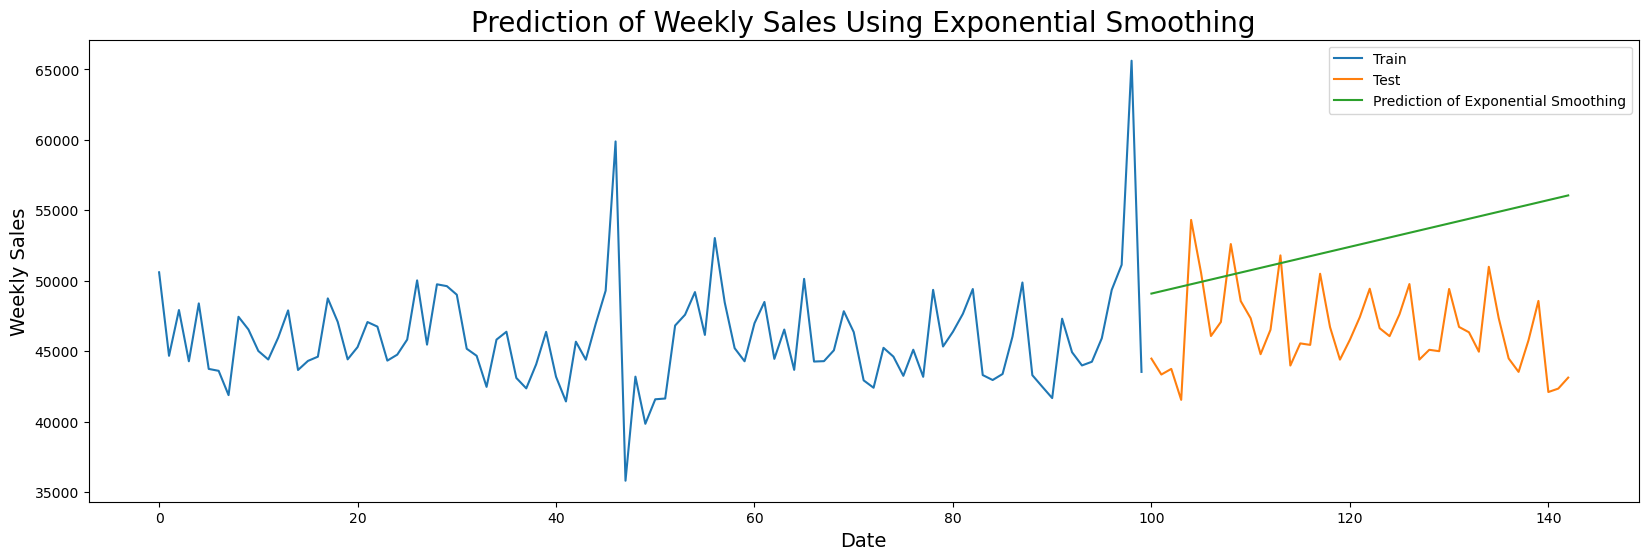

In [54]:
holt_linear = ExponentialSmoothing(
    train_data['Weekly_Sales'], 
    trend='add'
).fit()

holt_forecast = holt_linear.forecast(steps=len(test_data))
holt_metrics = metrics(test_data['Weekly_Sales'], holt_forecast, 'Holt Linear')
print(f"Holt Linear RMSE: {holt_metrics}")

plot_model(train_data['Weekly_Sales'], test_data['Weekly_Sales'], holt_forecast, 'Exponential Smoothing')

Holt-Winters RMSE: {'Model': 'Exponential Smoothing', 'RMSE': np.float64(4003.4240301529), 'MAE': 3277.3926319311636, 'MAPE': np.float64(7.141525948347454)}


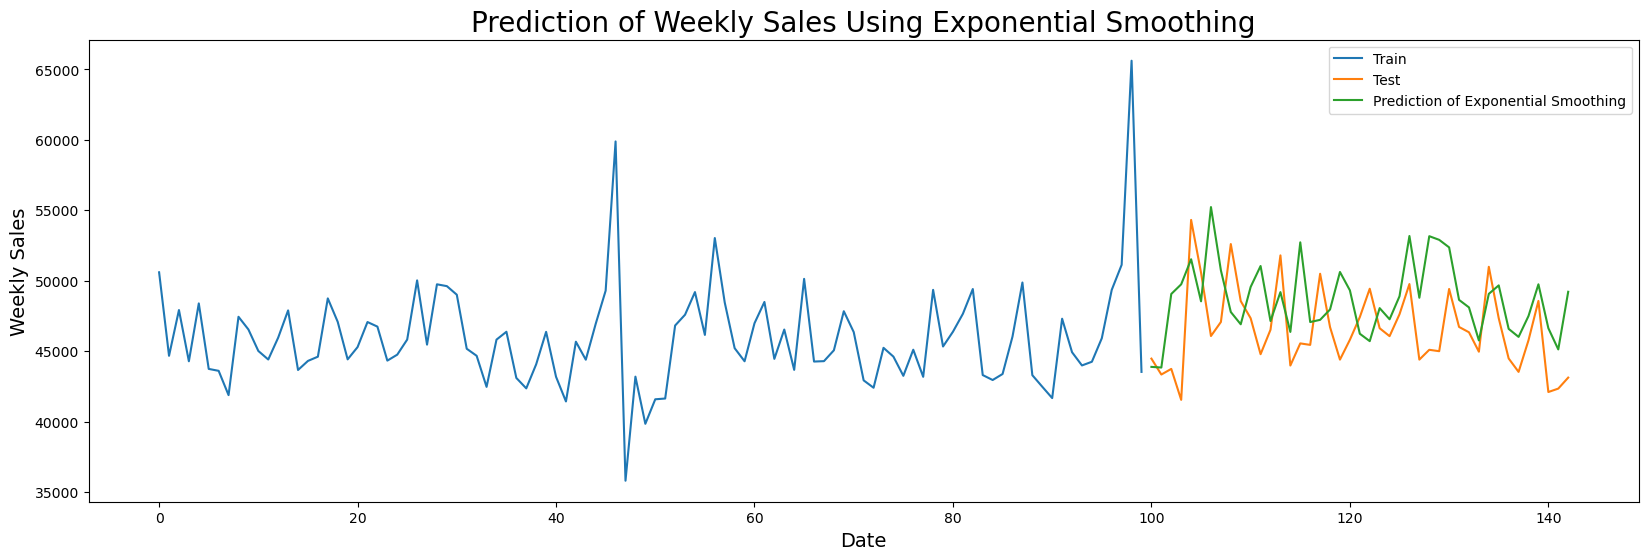

In [ ]:
    # Here we use Holt-Winters Exponential Smoothing with seasonal components
    ES = ExponentialSmoothing(
        train_data['Weekly_Sales'], 
        trend='add', 
        seasonal='add', 
        seasonal_periods= 50
    ).fit()

    ES_Forcast = ES.forecast(steps=len(test_data))
    ES_Metrics = metrics(test_data['Weekly_Sales'], ES_Forcast, 'Exponential Smoothing')
    print(f"Holt-Winters RMSE: {ES_Metrics}")

    plot_model(train_data['Weekly_Sales'], test_data['Weekly_Sales'], ES_Forcast, 'Exponential Smoothing')

ARIMA RMSE: {'Model': 'ARIMA', 'RMSE': 3124.0883730254172, 'MAE': 2709.715218698428, 'MAPE': 5.909205205613598}


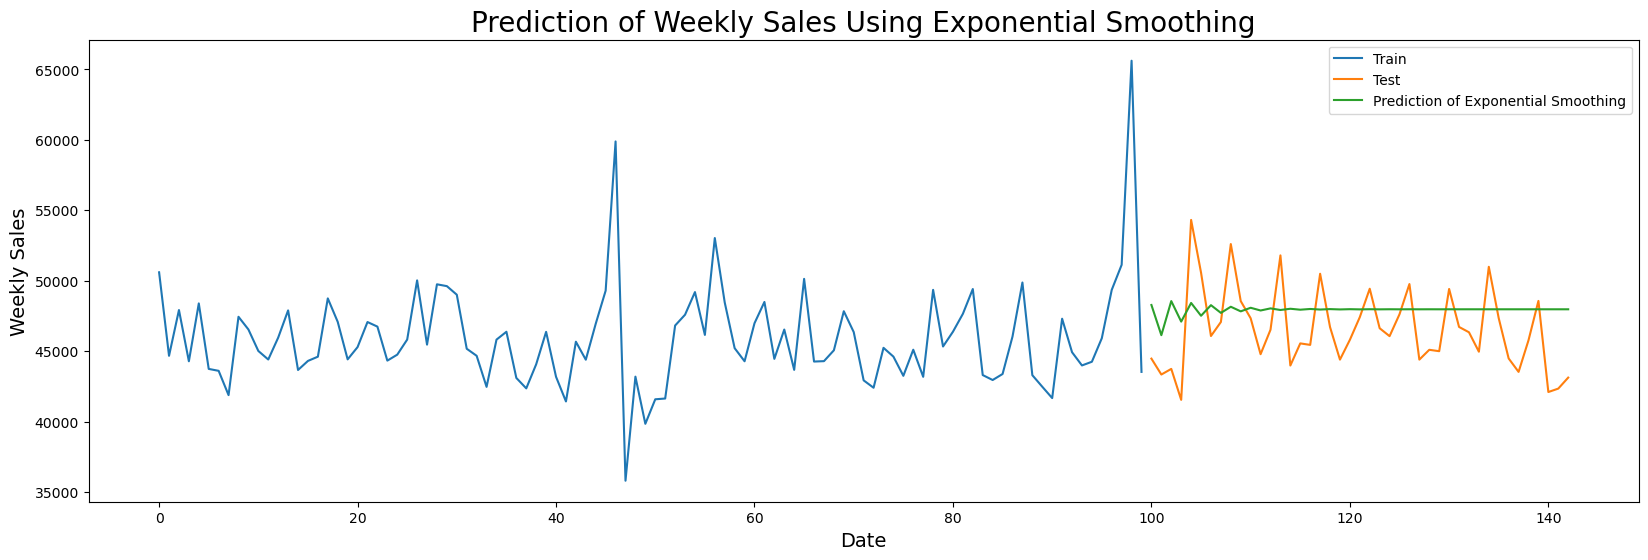

In [113]:
arima_model = ARIMA(train_data['Weekly_Sales'], order=(2, 1, 2)).fit()
arima_forecast = arima_model.forecast(steps=len(test_data))
arima_metrics = metrics(test_data['Weekly_Sales'], arima_forecast, 'ARIMA')
print(f"ARIMA RMSE: {arima_metrics}")

plot_model(train_data['Weekly_Sales'], test_data['Weekly_Sales'], arima_forecast, 'ARIMA')

Training SARIMA model...
SARIMA RMSE: {'Model': 'SARIMA', 'RMSE': 10134.137118066436, 'MAE': 8626.590874976873, 'MAPE': 18.90372940536771}


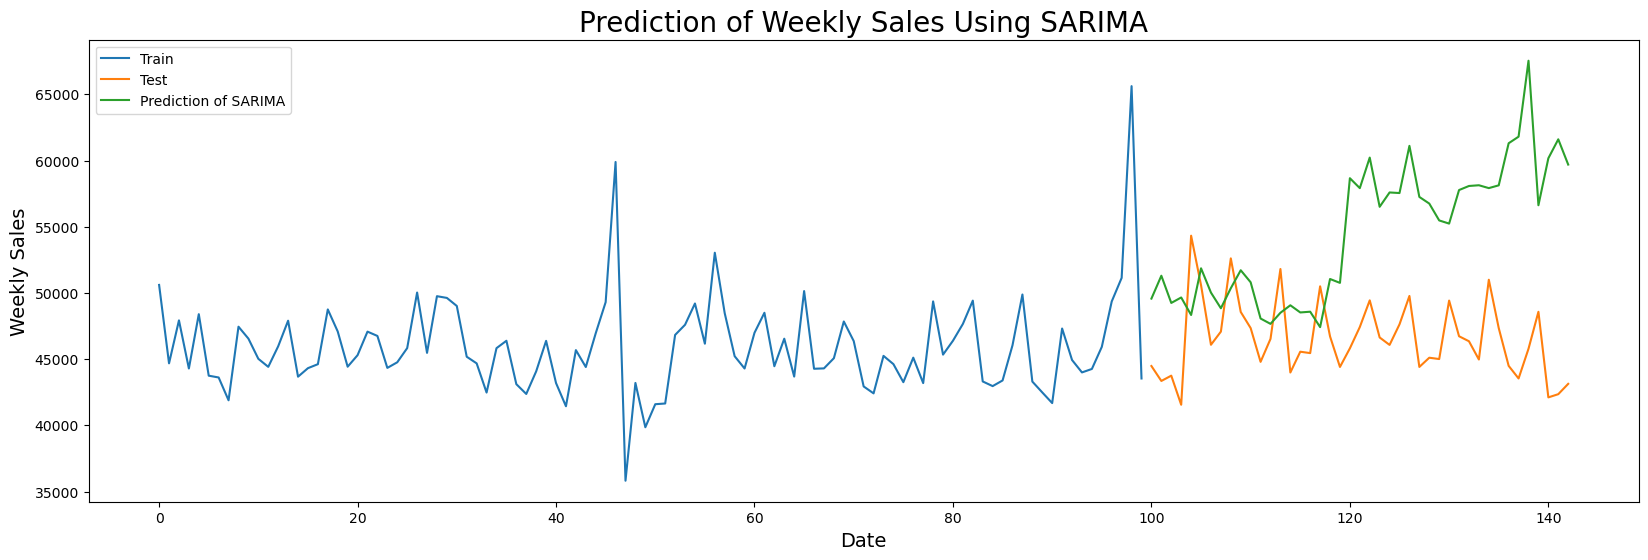

In [115]:
sarima_model = SARIMAX(
    train_data['Weekly_Sales'], 
    order=(1, 1, 1), 
    seasonal_order=(1, 1, 1, 40)
).fit()

sarima_forecast = sarima_model.forecast(steps=len(test_data))
sarima_metrics = metrics(test_data['Weekly_Sales'], sarima_forecast, 'SARIMA')
print(f"SARIMA RMSE: {sarima_metrics}")

plot_model(train_data['Weekly_Sales'], test_data['Weekly_Sales'], sarima_forecast, 'SARIMAX')

SARIMAX RMSE: {'Model': 'SARIMAX', 'RMSE': 17915.98378446164, 'MAE': 16510.020604076977, 'MAPE': 36.144298480487414}


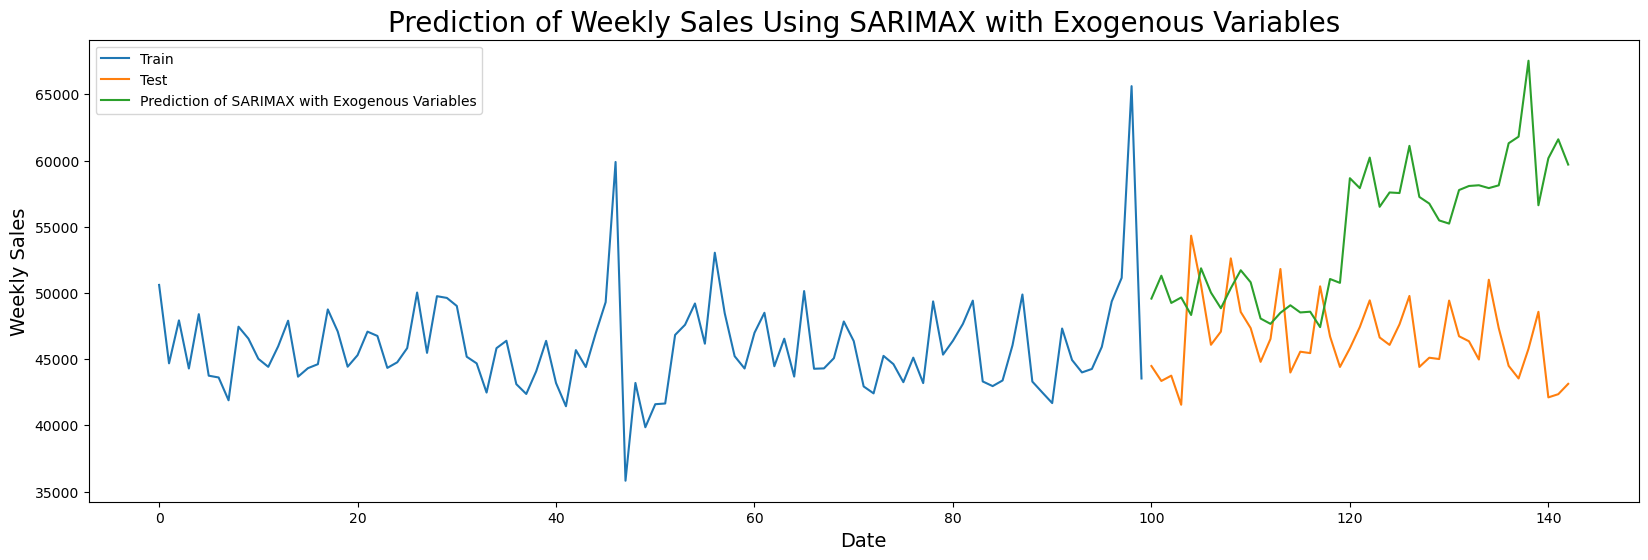

In [118]:
exog_features = ['Super_Bowl', 'Labor_Day', 'Thanksgiving', 'Christmas']
sarimax_model = SARIMAX(
    train_data['Weekly_Sales'], 
    exog=train_data[exog_features],
    order=(1, 1, 1), 
    seasonal_order=(1, 1, 1, 40)
).fit()

sarimax_forecast = sarimax_model.forecast(steps=len(test_data), exog=test_data[exog_features])
sarimax_metrics = metrics(test_data['Weekly_Sales'], sarimax_forecast, 'SARIMAX')
print(f"SARIMAX RMSE: {sarimax_metrics}")

plot_model(train_data['Weekly_Sales'], test_data['Weekly_Sales'], sarima_forecast, 'SARIMAX with Exogenous Variables')

In [71]:
# Prepare data for ML models
def prepare_ml_data(df_new):
    """Prepare data for machine learning models"""
    train_df = df_new[:int(0.7*(len(df_new)))] # taking train part
    test_df = df_new[int(0.7*(len(df_new))):] # taking test part

    # Select features (excluding target and date-related columns)
    feature_cols = [col for col in train_df.columns if col not in ['Weekly_Sales']]
    
    X_train = train_df[feature_cols].drop(columns=['Date'])
    y_train = train_df['Weekly_Sales']
    X_test = test_df[feature_cols].drop(columns=['Date'])
    y_test = test_df['Weekly_Sales']
    
    return X_train, y_train, X_test, y_test

In [72]:

X_train, y_train, X_test, y_test = prepare_ml_data(df_new)

Random Forest RMSE: {'Model': 'Random Forest', 'RMSE': 2261.1606523228293, 'MAE': 1717.6173139534874, 'MAPE': 3.596178339151717}


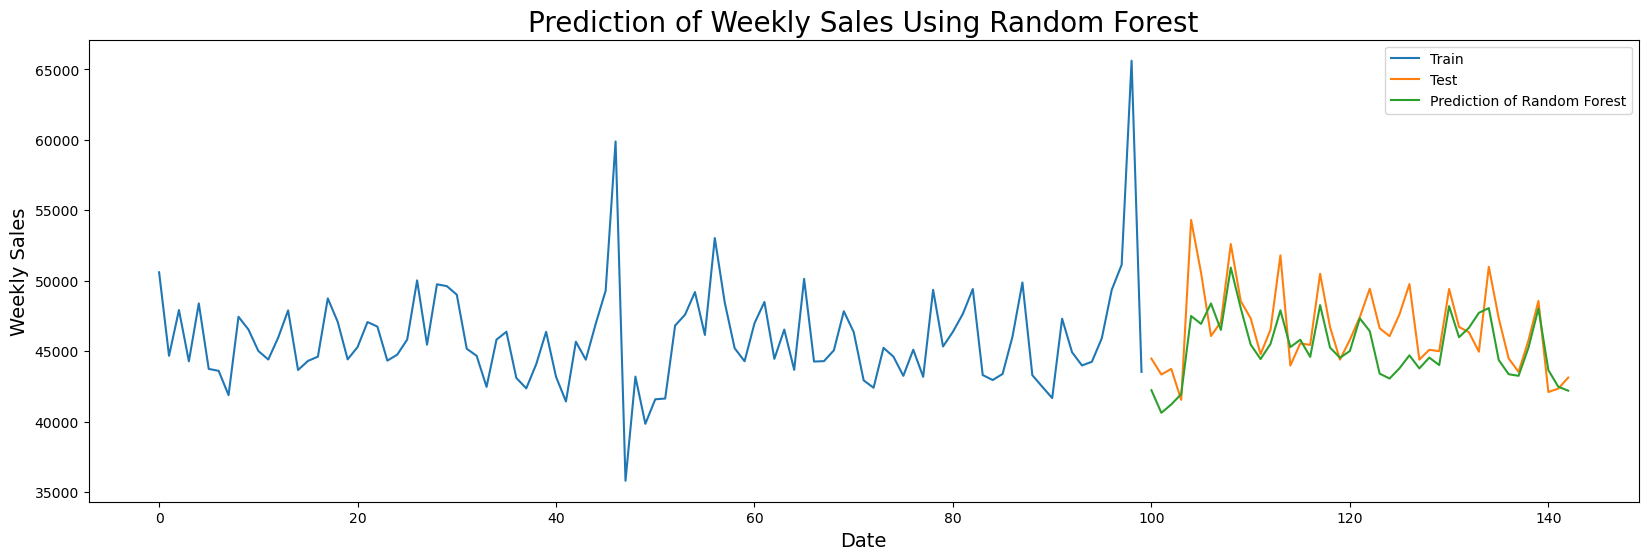

In [153]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_forecast = rf_model.predict(X_test)
rf_forecast = pd.Series(rf_forecast, index=test_data.index)
rf_metrics = metrics(y_test, rf_forecast, 'Random Forest')
print(f"Random Forest RMSE: {rf_metrics}")

plot_model(train_data['Weekly_Sales'], test_data['Weekly_Sales'], rf_forecast, 'Random Forest')

XGBoost RMSE: {'Model': 'XGBoost', 'RMSE': np.float64(2306.7378517295283), 'MAE': 1690.4914280523255, 'MAPE': np.float64(3.559607525990647)}


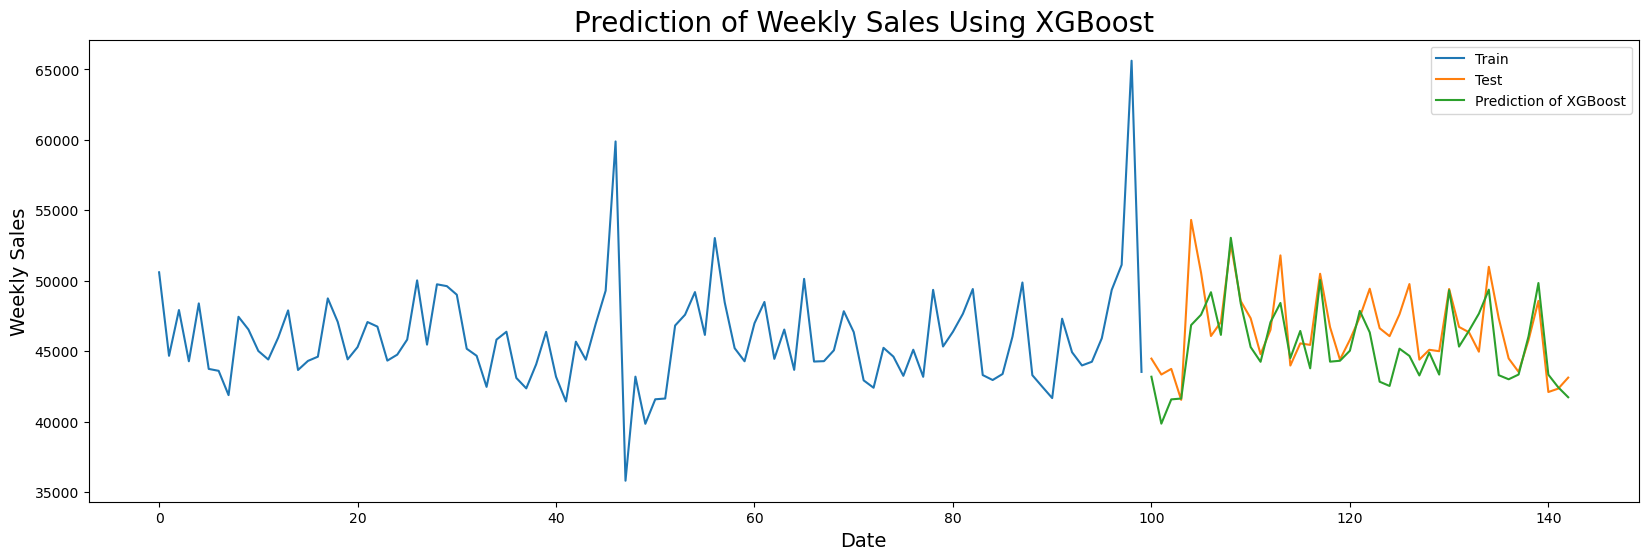

In [73]:
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
xgb_forecast = xgb_model.predict(X_test)
xgb_forecast= pd.Series(xgb_forecast, index=test_data.index)
xgb_metrics = metrics(y_test, xgb_forecast, 'XGBoost')
print(f"XGBoost RMSE: {xgb_metrics}")

plot_model(train_data['Weekly_Sales'], test_data['Weekly_Sales'], xgb_forecast, 'XGBoost')

# There's a problem while predicting by deep learning models which i don't know why


# Deep Learning 

In [55]:
def sequences(data, n_steps):
    """Create sequences for deep learning models"""
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

In [56]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_data[['Weekly_Sales']])
scaled_test = scaler.transform(test_data[['Weekly_Sales']])

n_steps = 12  # Use 12 weeks of data to predict next week
X_train_dl, y_train_dl = sequences(scaled_train.flatten(), n_steps)
X_test_dl, y_test_dl = sequences(scaled_test.flatten(), n_steps)

# Adjust test data length
y_test_dl_original = test_data['Weekly_Sales'].iloc[n_steps:].values

In [59]:
print("Training LSTM model...")
lstm_model = Sequential([
    LSTM(1028, return_sequences=True, input_shape=(n_steps, 1)),
    LSTM(1028, return_sequences=False),
    Dense(512, activation='relu'),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
X_train_dl_reshaped = X_train_dl.reshape((X_train_dl.shape[0], X_train_dl.shape[1], 1))
X_test_dl_reshaped = X_test_dl.reshape((X_test_dl.shape[0], X_test_dl.shape[1], 1))

lstm_model.fit(
    X_train_dl_reshaped, y_train_dl,
    validation_split=0.1,
    epochs=50, batch_size=32,
    callbacks=[early_stopping], verbose=0
)

lstm_forecast_scaled = lstm_model.predict(X_test_dl_reshaped)
lstm_forecast = scaler.inverse_transform(lstm_forecast_scaled).flatten()
lstm_metrics = metrics(y_test_dl_original, lstm_forecast, 'LSTM')
print(f"LSTM RMSE: {lstm_metrics}") 

Training LSTM model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
LSTM RMSE: {'Model': 'LSTM', 'RMSE': np.float64(2241.0703536697724), 'MAE': 1696.5319153225812, 'MAPE': np.float64(3.615377344249742)}


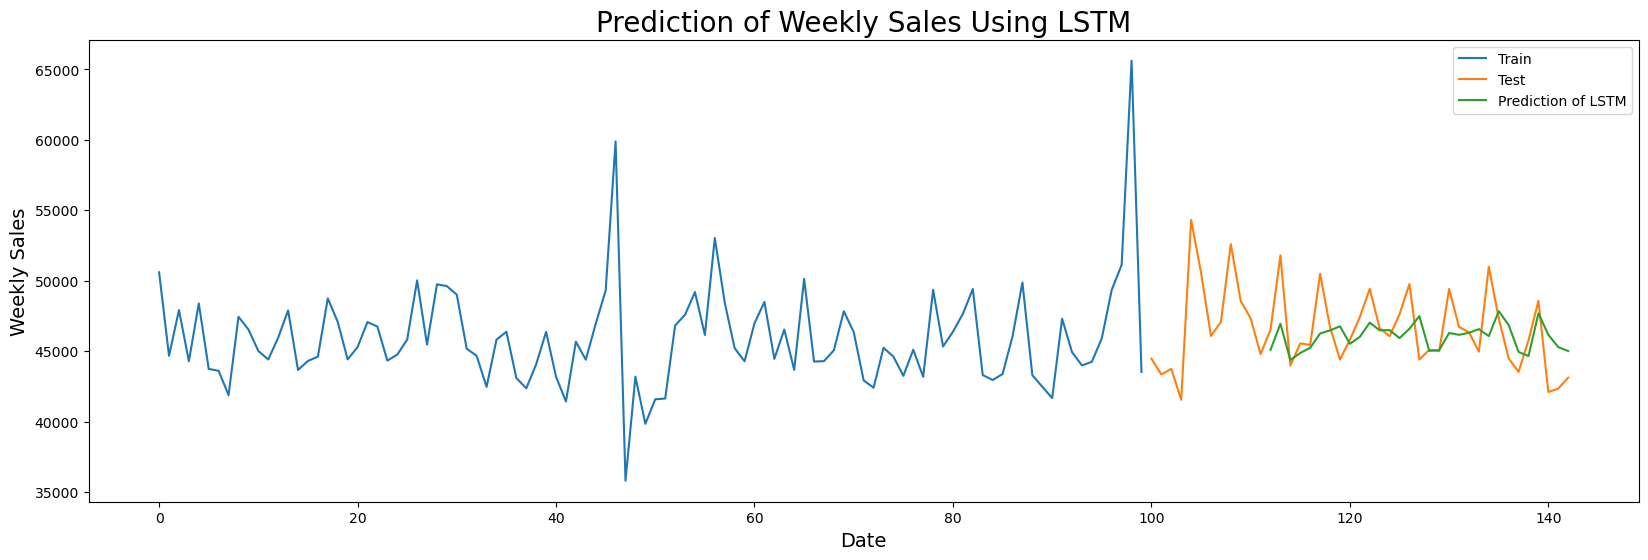

In [60]:
deep_plot_model(train_data['Weekly_Sales'], test_data['Weekly_Sales'], lstm_forecast, 'LSTM', n_steps=12)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
GRU RMSE: {'Model': 'GRU', 'RMSE': np.float64(2362.9001854826197), 'MAE': 1813.8756098790327, 'MAPE': np.float64(3.8525997942249735)}


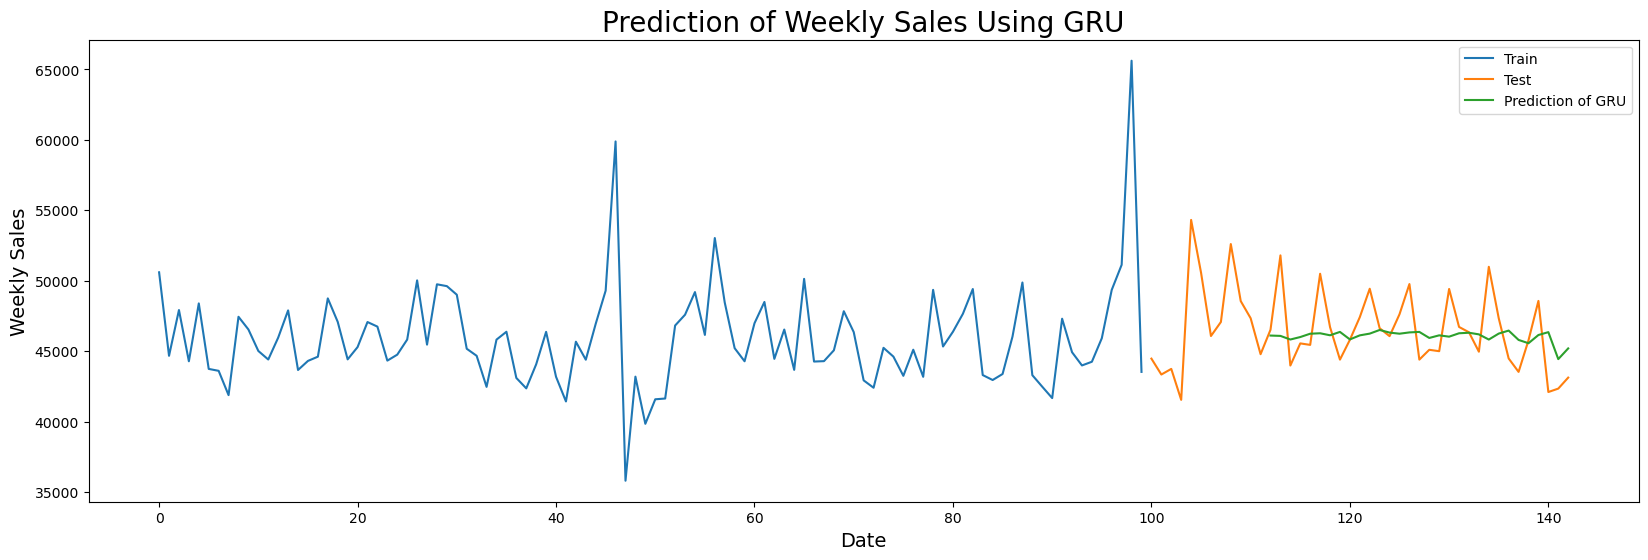

In [61]:
gru_model = Sequential([
    GRU(2048, return_sequences=True, input_shape=(n_steps, 1)),
    GRU(2048, return_sequences=False),
    Dense(512, activation='relu'),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')

gru_model.fit(
    X_train_dl_reshaped, y_train_dl,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=0
)

gru_forecast_scaled = gru_model.predict(X_test_dl_reshaped)
gru_forecast = scaler.inverse_transform(gru_forecast_scaled).flatten()
gru_metrics = metrics(y_test_dl_original, gru_forecast, 'GRU')
print(f"GRU RMSE: {gru_metrics}")

deep_plot_model(train_data['Weekly_Sales'], test_data['Weekly_Sales'], gru_forecast, 'GRU', n_steps=12)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
CNN RMSE: {'Model': 'CNN', 'RMSE': np.float64(1998.7876045163475), 'MAE': 1658.1227368951616, 'MAPE': np.float64(3.529294236365817)}


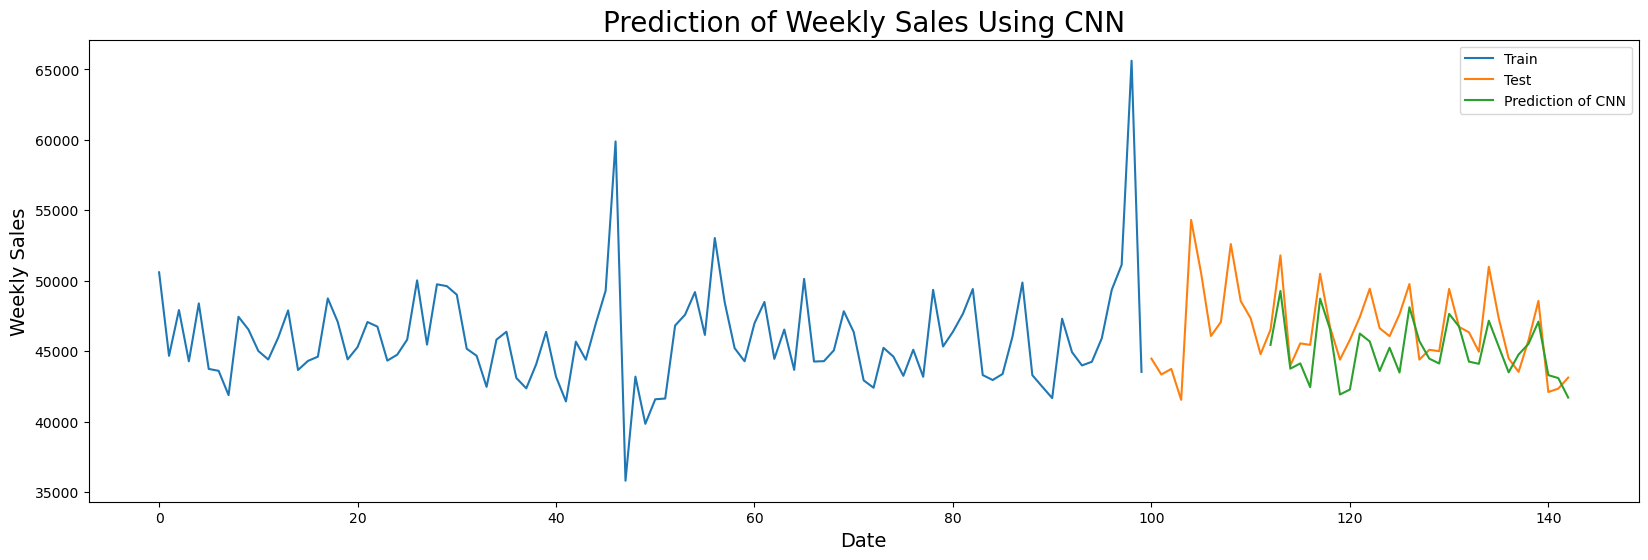

In [62]:
cnn_model = Sequential([
    
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps, 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)
])
cnn_model.compile(optimizer='adam', loss='mse')

cnn_model.fit(X_train_dl_reshaped, y_train_dl, epochs=32, batch_size=32, 
              callbacks=[early_stopping], verbose=0)

cnn_forecast_scaled = cnn_model.predict(X_test_dl_reshaped)
cnn_forecast = scaler.inverse_transform(cnn_forecast_scaled).flatten()
cnn_metrics = metrics(y_test_dl_original, cnn_forecast, 'CNN')
print(f"CNN RMSE: {cnn_metrics}")

deep_plot_model(train_data['Weekly_Sales'], test_data['Weekly_Sales'], cnn_forecast, "CNN", n_steps=12)


# Prohpet

In [ ]:
full_df = pd.read_csv('..\data\clean_data.csv')

# Splitting into train and test as per your plots (e.g., first 100 for train, rest for test)
train_prophet_df = full_df.iloc[:100].rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})
test_prophet_df = full_df.iloc[100:].rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})

train_prophet_df['ds'] = pd.to_datetime(train_prophet_df['ds'])
test_prophet_df['ds'] = pd.to_datetime(test_prophet_df['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])


model = Prophet(
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.05 # Adjust this for trend flexibility (default 0.05)
)

model.fit(train_prophet_df)

future_dates = model.make_future_dataframe(periods=len(test_prophet_df), freq='W')

forecast = model.predict(future_dates)

# Ensure all date columns are datetime
train_prophet_df['ds'] = pd.to_datetime(train_prophet_df['ds'])
test_prophet_df['ds'] = pd.to_datetime(test_prophet_df['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Plotting
plt.figure(figsize=(20, 6))
plt.plot(train_prophet_df['ds'], train_prophet_df['y'], label='Train')
plt.plot(test_prophet_df['ds'], test_prophet_df['y'], label='Test')
plt.plot(forecast['ds'].iloc[-len(test_prophet_df):], forecast['yhat'].iloc[-len(test_prophet_df):],
         label='Prediction of Prophet', color='green')
plt.title('Prediction of Weekly Sales Using Prophet')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.show()

# --- 5. Evaluate Metrics ---
# Extract the predictions corresponding to the test set
prophet_forecast_test = forecast['yhat'].iloc[-len(test_prophet_df):]


# Innovation using Nueral Prophet

In [ ]:

# --- Load and Prepare Data ---
df = pd.read_csv('..\data\clean_data.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]  # ✅ Drop Unnamed columns
df['Date'] = pd.to_datetime(df['Date'])
df = df.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'})
train_df = df.iloc[:100]
test_df = df.iloc[100:]
forecast_horizon = len(test_df)




# --- NeuralProphet ---
model_np = NeuralProphet(yearly_seasonality=True, weekly_seasonality=True)

# Drop extra columns
neural_df = train_df[['ds', 'y']]

# Fit the model
model_np.fit(neural_df, freq='W')

# Use the same cleaned df for future
future_np = model_np.make_future_dataframe(neural_df, periods=forecast_horizon)

# Predict
forecast_neuralprophet = model_np.predict(future_np)['yhat1'].iloc[-forecast_horizon:]


# --- Plotting All Models ---
models = {
    
    'NeuralProphet': forecast_neuralprophet.values
}

plt.figure(figsize=(20, 30))
for i, (name, pred) in enumerate(models.items(), 1):
    plt.subplot(6, 1, i)
    plt.plot(test_df['ds'], test_df['y'], label='Actual', color='black')
    plt.plot(test_df['ds'], pred, label=f'{name} Forecast', color='green')
    plt.title(f'{name} - Weekly Sales Forecast')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()


# Now so far.. I would like to go with XGBoost as my final choice

In [ ]:
import joblib
import os


# Save the trained XGBoost model
joblib.dump(xgb_model, '../model/xgb_model.pkl')
print("Model saved to model/xgb_model.pkl")

Model saved to model/xgb_model.pkl
